# Analysing and Cleaning the datset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_json('/content/drive/MyDrive/HackZurich_2022/Datasets/users.json')

In [ ]:
df_interest=df[df['model']=='schindler.userprofile']

In [ ]:
df_interest.reset_index(inplace=True)

In [ ]:
df_final= pd.DataFrame(columns=['Name','Interests','Cluster','Journey Frequency'])

In [ ]:
for ind in df_interest.index: 
  dict_person=df_interest['fields'][ind]
  df_final.loc[len(df_final.index)] = [dict_person['name'],dict_person['interests'],dict_person['cluster'],dict_person['journey_frequency']]


In [ ]:
df_final

,Name,Interests,Cluster,Journey Frequency
0,Michael Delker,"movie,adventure,science,politics,fashion,culture",None,702
1,Aaron Calder,"science,politics,culture,adventure,food,movie",None,518
2,James Higgins,"food,pets",None,970
3,Alicia Hudson,"food,pets,science,joke,adventure,movie,sports",None,2
4,Alice Schmidt,"fashion,science,food,joke,adventure,politics,m...",None,772
...,...,...,...,...
22262,Helen Ferullo,"sports,adventure,food,fashion",None,139
22263,Tammy Low,movie,None,331
22264,Steven Jarvis,fashion,None,566
22265,Fernando Lupo,science,None,671


In [ ]:
df_final.to_csv('/content/drive/MyDrive/HackZurich_2022/Datasets/cleaned_dataset.csv',index=False)

# Lets Play with clustering

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer 

# data
import pandas as pd
import numpy as np
import os
import json

# viz
import matplotlib.pyplot as plt
%matplotlib inline

# other
from tqdm import tqdm
from copy import deepcopy
import time


nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
import re
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    print(tokens)
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # print(tokens)
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    # print(filtered_tokens)
    return filtered_tokens

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df_final['Interests']) #fit the vectorizer to synopses

CPU times: user 3.39 s, sys: 29 ms, total: 3.42 s
Wall time: 3.43 s


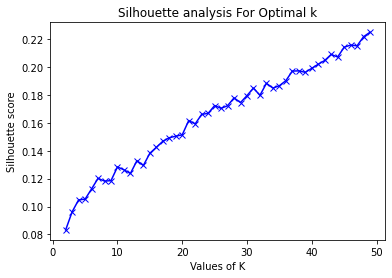

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters =range(2,50)
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(tfidf_matrix)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(tfidf_matrix, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

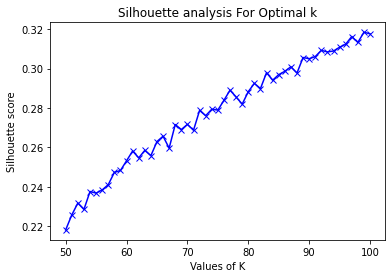

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters =range(50,101)
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(tfidf_matrix)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(tfidf_matrix, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

It seems we need more cluster in order to represent the underlying dataset

In [ ]:
kmeans = KMeans(n_clusters=500)
kmeans.fit(tfidf_matrix)
cluster_labels = kmeans.labels_

# silhouette score
print(silhouette_score(tfidf_matrix, cluster_labels))

0.6773603250544711


In [ ]:
kmeans = KMeans(n_clusters=600)
kmeans.fit(tfidf_matrix)
cluster_labels = kmeans.labels_

# silhouette score
print(silhouette_score(tfidf_matrix, cluster_labels))

0.7552722840394959


In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

num_clusters = 600

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
df_final['Cluster']=km.labels_
df_final.to_csv('/content/drive/MyDrive/HackZurich_2022/Datasets/cleaned_dataset_with_clusters.csv',index=False)

CPU times: user 56 s, sys: 37.9 s, total: 1min 33s
Wall time: 1min 28s


In [ ]:
import joblib



joblib.dump(km,  '/content/drive/MyDrive/HackZurich_2022/Saved Models/Km_model.pkl')
joblib.dump(tfidf_vectorizer,  '/content/drive/MyDrive/HackZurich_2022/Saved Models/tfidf_vector_model.pkl')



['/content/drive/MyDrive/HackZurich_2022/Saved Models/tfidf_vector_model.pkl']